In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler


np.random.seed(42)


#Simulate correlated dataset

n_samples = 500
n_factors = 3
n_features = 6

#Generate latent factors
latent_factors = np.random.randn(n_samples, n_factors)

#Loadings matrix (how latent factors influence observed variables)
loadings = np.array([
    [0.8, 0.3, 0.1],
    [0.7, 0.4, 0.2],
    [0.6, 0.2, 0.5],
    [0.2, 0.7, 0.4],
    [0.1, 0.8, 0.6],
    [0.3, 0.6, 0.7]
])

#in stock market analysis for fundamental factors, one of the ways to find loadings is through regression 
# Generate observed data with noise
X = latent_factors @ loadings.T + np.random.randn(n_samples, n_features) * 0.3
X = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(n_features)])


#Standardize and run Factor Analysis (MLE happens here)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Initialize Factor Analysis model (MLE estimation via EM algorithm)
fa = FactorAnalysis(n_components=3, rotation='varimax', random_state=42)
X_factors = fa.fit_transform(X_scaled)  #MLE is done internally here, using the EM algorithm. What is that?

#Extract Factor Loadings
loadings_df = pd.DataFrame(
    fa.components_.T,
    columns=[f"Factor{i+1}" for i in range(3)],
    index=X.columns
)
print("\n Factor Loadings (MLE Estimated) ")
print(loadings_df)


#Scree Plot (using PCA eigenvalues)

pca_full = PCA().fit(X_scaled)
plt.figure(figsize=(6,4))
plt.plot(range(1, n_features+1), pca_full.explained_variance_, 'o-', linewidth=2)
plt.title("Scree Plot (PCA Eigenvalues)")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue (Variance Explained)")
plt.grid(True)
plt.show()


#Compare Factor Analysis vs PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("\n PCA Explained Variance Ratios ")
print(np.round(pca.explained_variance_ratio_, 3))

#Compare loadings side by side
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PCA{i+1}" for i in range(3)],
    index=X.columns
)
comparison = pd.concat([loadings_df, pca_loadings], axis=1)
print("\n Loadings Comparison: FA (MLE) vs PCA ")
print(comparison)


#Communality (variance explained by common factors)

communalities = np.sum(fa.components_.T**2, axis=1)
communalities_df = pd.DataFrame({
    "Variable": X.columns,
    "Communality": communalities
})
print("\n Communalities ")
print(communalities_df)


#Factor Scores (estimated latent variables)

factor_scores = pd.DataFrame(X_factors, columns=[f"Factor{i+1}" for i in range(3)])
print("\n Sample of Factor Scores ")
print(factor_scores.head())



#===============Some actual code below

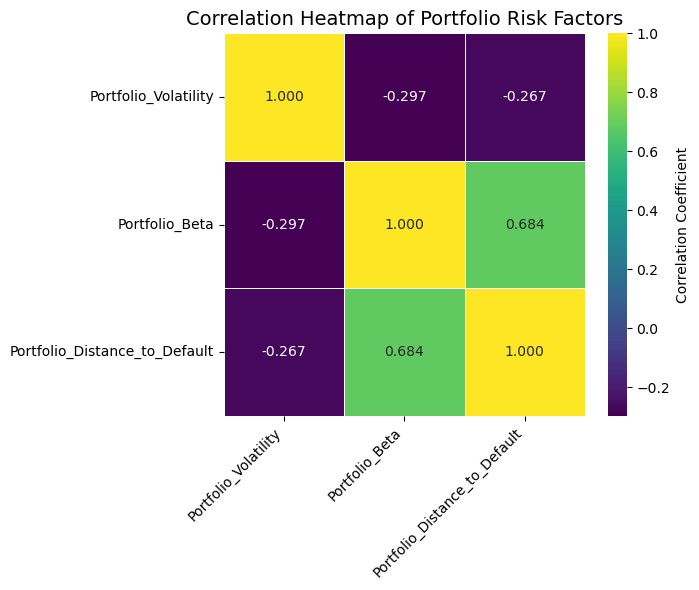

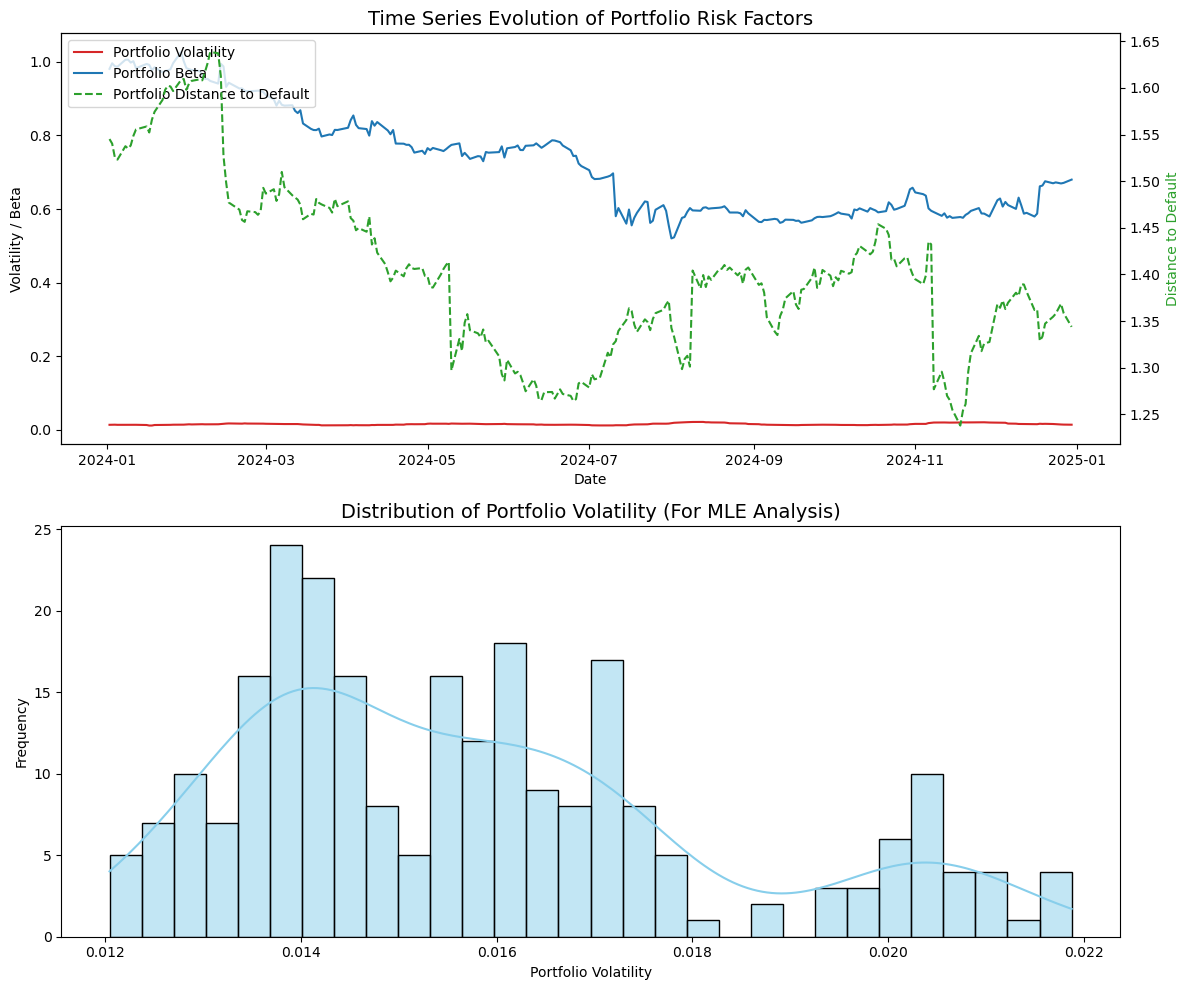


--- FACTOR LOADINGS (Varimax Rotated) ---
                               Factor_Systemic_Credit  Factor_Volatility
Portfolio_Volatility                        -0.304921           0.288424
Portfolio_Beta                               0.819631          -0.158257
Portfolio_Distance_to_Default                0.821594          -0.061684

--- FACTOR TIME SERIES HEAD (Daily Values) ---
            Factor_Systemic_Credit  Factor_Volatility
Date                                                 
2024-01-02                1.646410          -0.293141
2024-01-03                1.666511          -0.283601
2024-01-04                1.561719          -0.291915
2024-01-05                1.547688          -0.335425
2024-01-08                1.688249          -0.334697


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import t # Included for the previously run MLE analysis

# --- 1. DATA LOADING AND PORTFOLIO CONSTRUCTION ---

# FIX: Use the correct file name and format (CSV)
df_LRF= pd.read_excel('LRF.xlsx') #LRF= low-risk factors

df_LRF['Date'] = pd.to_datetime(df_LRF['Date'])

# Define column names explicitly for clarity
original_cols = ['Volatility', 'Beta', 'Distance_to_Default']
portfolio_cols = ['Portfolio_Volatility', 'Portfolio_Beta', 'Portfolio_Distance_to_Default']

# Clean data (handle NaNs)
df_cleaned = df_LRF.dropna(subset=original_cols)

# Construct portfolio series using original columns (daily mean = Equal-Weighted Portfolio)
df_portfolio_series = df_cleaned.groupby('Date')[original_cols].mean().reset_index()

# RENAME STEP: Apply the portfolio column names
df_portfolio_series.columns = ['Date'] + portfolio_cols


# --- 2. EDA VISUALIZATIONS (Heatmap and Time Series/Histogram) ---

# 2a. Correlation Heatmap
portfolio_corr = df_portfolio_series[portfolio_cols].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(portfolio_corr, annot=True, cmap='viridis', fmt=".3f", linewidths=.5, linecolor='white', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Portfolio Risk Factors', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 


# 2b. Time Series and Distribution Plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Top Plot (Time Series Evolution)
ax1 = axes[0]
ax2 = ax1.twinx() 
ax1.plot(df_portfolio_series['Date'], df_portfolio_series['Portfolio_Volatility'], label='Portfolio Volatility', color='tab:red')
ax1.plot(df_portfolio_series['Date'], df_portfolio_series['Portfolio_Beta'], label='Portfolio Beta', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility / Beta', color='black')
ax2.plot(df_portfolio_series['Date'], df_portfolio_series['Portfolio_Distance_to_Default'], label='Portfolio Distance to Default', color='tab:green', linestyle='--')
ax2.set_ylabel('Distance to Default', color='tab:green')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
ax1.set_title('Time Series Evolution of Portfolio Risk Factors', fontsize=14)

# Bottom Plot (Distribution of Portfolio Volatility)
ax_hist = axes[1]
sns.histplot(df_portfolio_series['Portfolio_Volatility'], bins=30, kde=True, ax=ax_hist, color='skyblue')
ax_hist.set_title('Distribution of Portfolio Volatility (For MLE Analysis)', fontsize=14)
ax_hist.set_xlabel('Portfolio Volatility')
ax_hist.set_ylabel('Frequency')
plt.tight_layout()
plt.show() 


# --- 3. FACTOR ANALYSIS (MLE ESTIMATION VIA EM) ---

# Select ONLY the portfolio factor columns for analysis
X = df_portfolio_series[portfolio_cols]

# 3a. Scaling: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3b. Initialize and Fit Factor Analysis model (n_components=2 based on PCA)
fa = FactorAnalysis(n_components=2, rotation='varimax', random_state=42)
df_portfolio_series_factors = fa.fit_transform(X_scaled) 

# --- 4. EXTRACT AND PRINT RESULTS ---

# 4a. Extract Factor Loadings 
loadings_df = pd.DataFrame(
    fa.components_.T,
    columns=["Factor_Systemic_Credit", "Factor_Volatility"], 
    index=portfolio_cols # Correctly using the portfolio column names
)

print("\n--- FACTOR LOADINGS (Varimax Rotated) ---")
print(loadings_df)

# 4b. Create Factor Time Series (The daily values of the two factors)
df_factors_time_series = pd.DataFrame(
    df_portfolio_series_factors, 
    columns=["Factor_Systemic_Credit", "Factor_Volatility"], 
    index=df_portfolio_series['Date']
)

print("\n--- FACTOR TIME SERIES HEAD (Daily Values) ---")
print(df_factors_time_series.head())

In [20]:
# --- ASSUMPTIONS: Imports and df_LRF are loaded. Need Factor Analysis libraries. ---
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

# --- 1. FACTOR SERIES RECONSTRUCTION (Must be done in this block) ---
# Define column names (must match your loading process)
original_cols = ['Volatility', 'Beta', 'Distance_to_Default']
portfolio_cols = ['Portfolio_Volatility', 'Portfolio_Beta', 'Portfolio_Distance_to_Default']

# Assuming df_LRF is available, clean and aggregate:
df_cleaned = df_LRF.dropna(subset=original_cols)
df_portfolio_series = df_cleaned.groupby('Date')[original_cols].mean().reset_index()
df_portfolio_series.columns = ['Date'] + portfolio_cols

# Run Factor Analysis to get the factor scores:
X = df_portfolio_series[portfolio_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
fa = FactorAnalysis(n_components=2, rotation='varimax', random_state=42)
df_portfolio_series_factors = fa.fit_transform(X_scaled) 

# Final Factor Time Series DataFrame
df_factors_time_series = pd.DataFrame(
    df_portfolio_series_factors, 
    columns=["Factor_Systemic_Credit", "Factor_Volatility"], 
    index=pd.to_datetime(df_portfolio_series['Date'])
)


# --- 2. HISTORICAL VAR BACKTEST ---

factor_data = df_factors_time_series['Factor_Systemic_Credit']
confidence_level = 0.95
expected_breach_rate = 1.0 - confidence_level
total_days = len(factor_data)

# Calculate the 95th percentile (VaR)
VaR_95 = factor_data.quantile(confidence_level)

# Perform the Backtest: Count breaches (factor value > VaR limit)
breaches = factor_data[factor_data > VaR_95]
num_breaches = len(breaches)
actual_breach_rate = num_breaches / total_days

# Print Results
print("--- Factor VaR Backtest Results (Factor: Systemic/Credit) ---")
print(f"Calculated 95% VaR (Factor Value Limit): {VaR_95:.4f}")
print(f"Expected Number of Breaches (5%): {expected_breach_rate * total_days:.1f}")
print(f"Actual Number of Breaches: {num_breaches}")
print(f"Actual Breach Rate: {actual_breach_rate * 100:.2f}%")

if actual_breach_rate > expected_breach_rate:
    print("\nCONCLUSION: VaR is violated. The model underestimates tail risk (fat tails).")
else:
    print("\nCONCLUSION: VaR is sound.")

--- Factor VaR Backtest Results (Factor: Systemic/Credit) ---
Calculated 95% VaR (Factor Value Limit): 1.9240
Expected Number of Breaches (5%): 12.6
Actual Number of Breaches: 13
Actual Breach Rate: 5.18%

CONCLUSION: VaR is violated. The model underestimates tail risk (fat tails).


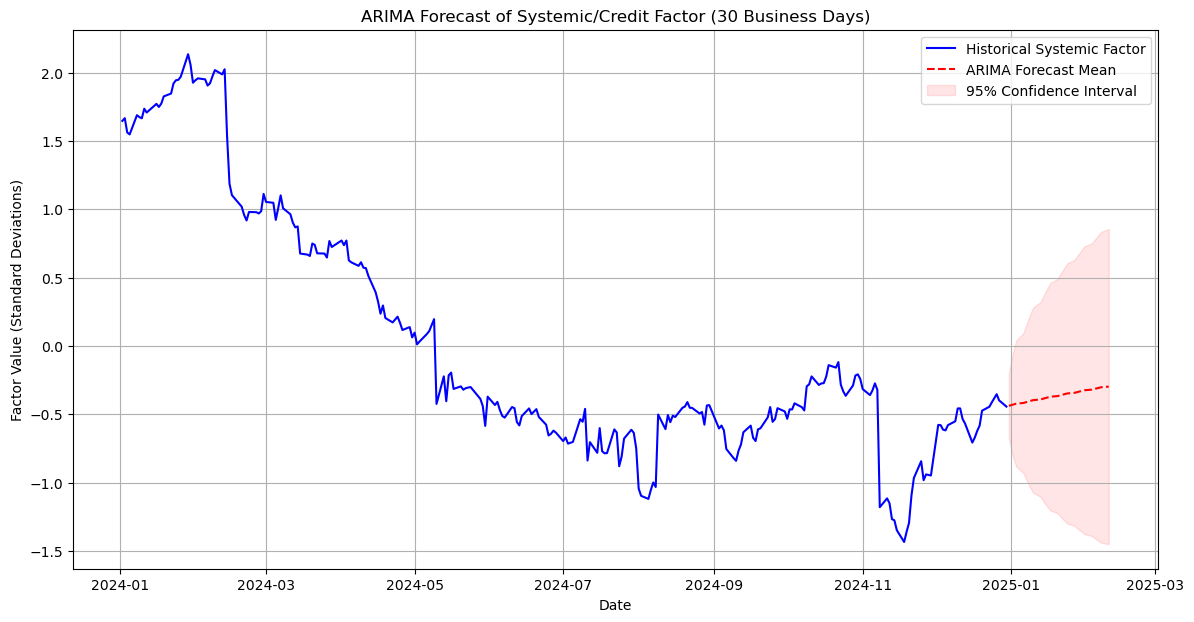

In [26]:
# --- ASSUMPTIONS: Imports and df_LRF are loaded. Need Factor Analysis and Statsmodels libraries. ---
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA 
import pandas as pd 
import numpy as np 

# --- 1. FACTOR SERIES RECONSTRUCTION ---
# Define column names (must match your loading process)
original_cols = ['Volatility', 'Beta', 'Distance_to_Default']
portfolio_cols = ['Portfolio_Volatility', 'Portfolio_Beta', 'Portfolio_Distance_to_Default']

# Assuming df_LRF is available, clean and aggregate:
df_cleaned = df_LRF.dropna(subset=original_cols)
df_portfolio_series = df_cleaned.groupby('Date')[original_cols].mean().reset_index()
df_portfolio_series.columns = ['Date'] + portfolio_cols

# Run Factor Analysis to get the factor scores:
X = df_portfolio_series[portfolio_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
fa = FactorAnalysis(n_components=2, rotation='varimax', random_state=42)
df_portfolio_series_factors = fa.fit_transform(X_scaled) 

# Final Factor Time Series DataFrame
df_factors_time_series = pd.DataFrame(
    df_portfolio_series_factors, 
    columns=["Factor_Systemic_Credit", "Factor_Volatility"], 
    index=pd.to_datetime(df_portfolio_series['Date'])
)


# --- 2. ARIMA FORECASTING MODEL (Prediction) ---

factor_data = df_factors_time_series['Factor_Systemic_Credit']

# 1. Fit ARIMA Model
# Using .values avoids the statsmodels frequency error
arima_model = ARIMA(factor_data.values, order=(1, 0, 0))
arima_fit = arima_model.fit()

# 2. Generate Forecast
forecast_steps = 30 
forecast = arima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int() # This output is a NumPy array

# 3. Create a clean date index for plotting the forecast
last_date = factor_data.index.max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='B')[1:] 


# 4. Plotting the Results
plt.figure(figsize=(14, 7))

# CRITICAL FIX 1: Change pandas plot to Matplotlib plot and pass the index explicitly
plt.plot(factor_data.index, factor_data.values, label='Historical Systemic Factor', color='blue')

# Plot the forecast
plt.plot(forecast_dates, forecast_mean, label='ARIMA Forecast Mean', color='red', linestyle='--')

# Plot confidence interval (using NumPy slicing)
plt.fill_between(
    forecast_dates,
    forecast_ci[:, 0],
    forecast_ci[:, 1],
    color='red', alpha=0.1, label='95% Confidence Interval'
)

plt.title(f'ARIMA Forecast of Systemic/Credit Factor ({forecast_steps} Business Days)')
plt.xlabel('Date')
plt.ylabel('Factor Value (Standard Deviations)')
plt.legend()
plt.grid(True)
plt.show()

